In [22]:
from __future__ import unicode_literals, print_function, division
from io import open
import os
import glob
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_hidden = 128
learning_rate = 0.005

n_iters = 100000
print_every = 5000
plot_every = 1000


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

def findFiles(path):
    return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters, device=device)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters, device=device)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


# print(findFiles('/data1/qpzm/data-char-rnn/names/*.txt'))
# print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

for filename in findFiles('/data1/qpzm/data-char-rnn/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
# print(category_lines['Italian'][:5])
# print(letterToTensor('J'))
# print(lineToTensor('Jones').size())


def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long, device=device)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    print(category_tensor)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")

rnn = nn.DataParallel(RNN(n_letters, n_hidden, n_categories))
rnn.to(device)
criterion = nn.NLLLoss()


def train(category_tensor, line_tensor):
    hidden = rnn.module.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    return '%dm %ds' % (s // 60, s % 60)

category = German / line = Buchholz
tensor([ 6], device='cuda:0')
category = Scottish / line = Aitken
tensor([ 5], device='cuda:0')
category = Spanish / line = Araullo
tensor([ 10], device='cuda:0')
category = English / line = Illing
tensor([ 11], device='cuda:0')
category = Spanish / line = Hierro
tensor([ 10], device='cuda:0')
category = Korean / line = Jon
tensor([ 13], device='cuda:0')
category = Irish / line = Connolly
tensor([ 17], device='cuda:0')
category = Chinese / line = Kan
tensor([ 8], device='cuda:0')
category = Irish / line = Sullivan
tensor([ 17], device='cuda:0')
category = Chinese / line = Teoh
tensor([ 8], device='cuda:0')
Let's use 4 GPUs!


In [23]:
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'o' if guess == category else 'x (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 33s) 3.3828 Cheetham / Polish x (English)
10000 10% (1m 7s) 0.8625 Tao / Chinese o
15000 15% (1m 41s) 1.7788 Arian / Irish x (Arabic)
20000 20% (2m 16s) 0.9730 Mikolajczak / Polish o
25000 25% (2m 50s) 1.7022 Quraishi / Japanese x (Arabic)
30000 30% (3m 25s) 3.6672 Ogterop / French x (Dutch)
35000 35% (3m 59s) 0.4151 Tsuda / Japanese o
40000 40% (4m 35s) 1.0488 Li / Vietnamese x (Korean)
45000 45% (5m 9s) 2.3358 Ferraro / Portuguese x (Italian)
50000 50% (5m 44s) 0.0681 Kusunoki / Japanese o
55000 55% (6m 20s) 2.6267 Gosselin / Russian x (French)
60000 60% (6m 56s) 1.7475 Schneijder / German x (Dutch)
65000 65% (7m 30s) 3.2834 Padovan / Irish x (Italian)
70000 70% (8m 5s) 1.4190 Bissette / French o
75000 75% (8m 39s) 0.8279 Niall / Irish o
80000 80% (9m 14s) 0.9276 Bureau / French o
85000 85% (9m 48s) 1.1045 Pavia / Spanish o
90000 90% (10m 22s) 1.4367 Lonsdale / English o
95000 95% (10m 56s) 2.8363 Schermer / German x (Dutch)
100000 100% (11m 29s) 0.0339 Christakos / Greek

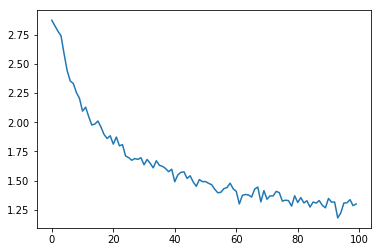

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [29]:
import numpy as np

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.module.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [40]:
correct = np.trace(confusion.numpy())
print("accuracy: %d %%" % (correct / n_confusion * 100))

accuracy: 58 %


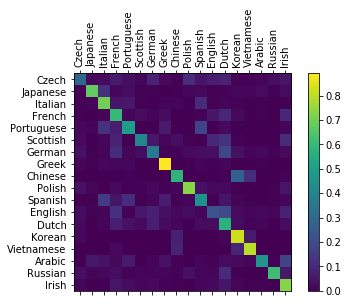

In [44]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()